# This requires a set of geospatial packages not included in ewatercycle


In [1]:
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from IPython.display import IFrame
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
import os
import xarray as xr
from datetime import datetime
from pathlib import Path

In [2]:
path = Path.cwd()

figure_path = path / "Figures"
analysis_path = path.parent/ 'nbs_40_run_all_camels' / "Analysis" 

In [3]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

## load characteristic files

In [4]:
geospatial_files = analysis_path / "camels_characteristics" 

In [5]:
lst_paths_characteristic = list(geospatial_files.glob('*.feather'))

In [6]:
lst_char_df = []
for path in lst_paths_characteristic:
    df = pd.read_feather(path).set_index('gauge_id')
    df.index.name = "HRU_id"
    lst_char_df.append(df)

In [7]:
df_char_names = lst_char_df[0]
df_char_names.head(3)

huc_02                                   gauge_name
HRU_id                                                      
1013500       1             Fish River near Fort Kent, Maine
1022500       1      Narraguagus River at Cherryfield, Maine
1030500       1  Mattawamkeag River near Mattawamkeag, Maine

In [8]:
df_char_clim = lst_char_df[1]
df_char_clim.head(3)

p_mean  pet_mean  p_seasonality  frac_snow   aridity  \
HRU_id                                                            
1013500  3.126679  1.971555       0.187940   0.313440  0.630559   
1022500  3.608126  2.119256      -0.114530   0.245259  0.587356   
1030500  3.274405  2.043594       0.047358   0.277018  0.624111   

         high_prec_freq  high_prec_dur high_prec_timing  low_prec_freq  \
HRU_id                                                                   
1013500           12.95       1.348958              son         202.20   
1022500           20.55       1.205279              son         233.65   
1030500           17.15       1.207746              son         215.60   

         low_prec_dur low_prec_timing  
HRU_id                                 
1013500      3.427119             mam  
1022500      3.662226             jja  
1030500      3.514262             djf

In [9]:
df_char_geol = lst_char_df[2]
df_char_geol.head(3)

geol_1st_class  glim_1st_class_frac  \
HRU_id                                                          
1013500  Siliciclastic sedimentary rocks             0.815904   
1022500              Acid plutonic rocks             0.590658   
1030500  Siliciclastic sedimentary rocks             0.573305   

                          geol_2nd_class  glim_2nd_class_frac  \
HRU_id                                                          
1013500             Basic volcanic rocks             0.179729   
1022500  Siliciclastic sedimentary rocks             0.164618   
1030500                     Metamorphics             0.287010   

         carbonate_rocks_frac  geol_porostiy  geol_permeability  
HRU_id                                                           
1013500               0.00000         0.1714           -14.7019  
1022500               0.00000         0.0710           -14.2138  
1030500               0.05214         0.1178           -14.4918

In [10]:
df_char_hydro= lst_char_df[3]
df_char_hydro.head(3)

q_mean  runoff_ratio  slope_fdc  baseflow_index  stream_elas  \
HRU_id                                                                    
1013500  1.699155      0.543437   1.528219        0.585226     1.845324   
1022500  2.173062      0.602269   1.776280        0.554478     1.702782   
1030500  1.820108      0.555859   1.871110        0.508441     1.377505   

               q5       q95  high_q_freq  high_q_dur  low_q_freq  low_q_dur  \
HRU_id                                                                        
1013500  0.241106  6.373021         6.10    8.714286       41.35  20.170732   
1022500  0.204734  7.123049         3.90    2.294118       65.15  17.144737   
1030500  0.107149  6.854887        12.25    7.205882       89.25  19.402174   

         zero_q_freq  hfd_mean  
HRU_id                          
1013500          0.0    207.25  
1022500          0.0    166.25  
1030500          0.0    184.90

In [11]:
df_char_soil = lst_char_df[4]
df_char_soil.head(3)

soil_depth_pelletier  soil_depth_statsgo  soil_porosity  \
HRU_id                                                             
1013500              7.404762            1.248408       0.461149   
1022500             17.412808            1.491846       0.415905   
1030500             19.011414            1.461363       0.459091   

         soil_conductivity  max_water_content  sand_frac  silt_frac  \
HRU_id                                                                
1013500           1.106522           0.558055  27.841827  55.156940   
1022500           2.375005           0.626229  59.390156  28.080937   
1030500           1.289807           0.653020  32.235458  51.779182   

         clay_frac  water_frac  organic_frac  other_frac  
HRU_id                                                    
1013500  16.275732    5.376698      0.408717    0.000000  
1022500  12.037646    1.226913      0.000000    0.358472  
1030500  14.776824    1.634345      1.330278    0.022016

In [12]:
df_char_vege = lst_char_df[5]
df_char_vege.head(3)

frac_forest   lai_max  lai_diff   gvf_max  gvf_diff  \
HRU_id                                                         
1013500       0.9063  4.167304  3.340732  0.804567  0.371648   
1022500       0.9232  4.871392  3.746692  0.863936  0.337712   
1030500       0.8782  4.685200  3.665543  0.858502  0.351393   

         dom_land_cover_frac dom_land_cover  root_depth_50  root_depth_99  
HRU_id                                                                     
1013500             0.883452  Mixed Forests            NaN            NaN  
1022500             0.820493  Mixed Forests       0.237435       2.238444  
1030500             0.975258  Mixed Forests            NaN            NaN

In [13]:
gdf_catchments = gpd.read_file(geospatial_files / "catchments.gpkg")
gdf_catchments = gdf_catchments[['hru_id','geometry']]
gdf_catchments = gdf_catchments.set_index('hru_id')
gdf_catchments.index.name = "HRU_id"

<Axes: >

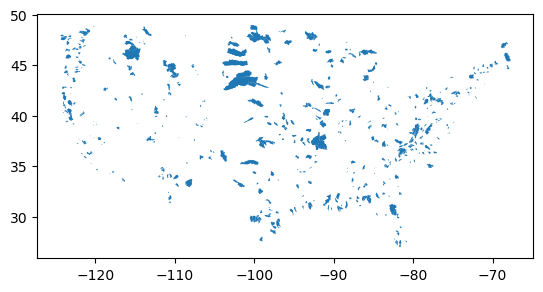

In [14]:
gdf_catchments.plot()

In [15]:
gdf_gauges = gpd.read_file(geospatial_files / "gauges.gpkg")
gdf_gauges = gdf_gauges.set_index('gauge_id')
gdf_gauges.index.name = "HRU_id"
gdf_gauges

gauge_lat  gauge_lon  elev_mean  slope_mean  area_gages2  \
HRU_id                                                               
1013500    47.23739  -68.58264     250.31    21.64152      2252.70   
1022500    44.60797  -67.93524      92.68    17.79072       573.60   
1030500    45.50097  -68.30596     143.80    12.79195      3676.17   
1031500    45.17501  -69.31470     247.80    29.56035       769.05   
1047000    44.86920  -69.95510     310.38    49.92122       909.10   
...             ...        ...        ...         ...          ...   
14309500   42.80400 -123.61091     709.83   110.42527       224.92   
14316700   43.34984 -122.72894     952.26   119.08920       587.90   
14325000   42.89150 -124.07065     656.53   124.96889       443.07   
14362250   42.15401 -123.07532     875.67   109.93127        41.42   
14400000   42.12344 -124.18731     625.31    98.81802       702.63   

          area_geospa_fabric                     geometry  
HRU_id                                                     
1013500              2303.95   POINT (-68.58264 47.23739)  
1022500               620.38   POINT (-67.93524 44.60797)  
1030500              3676.09   POINT (-68.30596 45.50097)  
1031500               766.53   POINT (-69.31470 45.17501)  
1047000               904.94   POINT (-69.95510 44.86920)  
...                      ...                          ...  
14309500              226.31  POINT (-123.61091 42.80400)  
14316700              588.01  POINT (-122.72894 43.34984)  
14325000              444.92  POINT (-124.07065 42.89150)  
14362250               43.88  POINT (-123.07532 42.15401)  
14400000              703.37  POINT (-124.18731 42.12344)  

[671 rows x 7 columns]

In [16]:
hru_id_cal = ['01137500',
            '01139800',
            '01187300',
            '01052500',
            '01073000',
            '01181000',
            '01169000',
            '01013500',
            '01123000',
            '01055000',
            '01047000',
            '04296000',
            '01022500',
            '01134500',
            '01170100',
            '01142500',
            '01144000',
            '01054200',
            '01031500',
            '01139000',
            '01057000',
            '01078000',
            '01162500',
            '01030500',
            '01118300',
            '01121000']
for index, ids in enumerate(hru_id_cal):
    hru_id_cal[index] = int(ids)
gdf_callibration_catchment = gdf_catchments.loc[hru_id_cal]
gdf_callibration_gauges = gdf_gauges.loc[hru_id_cal]

### plotting to check 

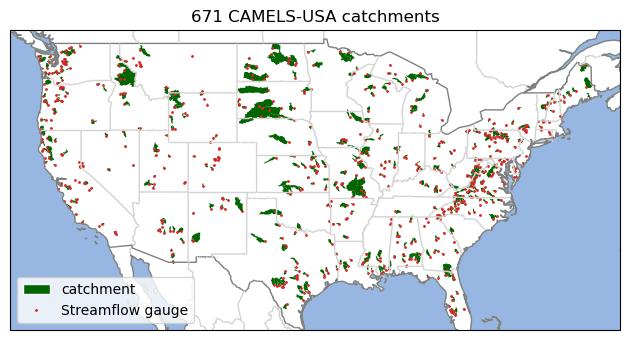

In [17]:
# set up background maps
ax = plt.axes(projection=ccrs.PlateCarree())
country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none')
ax.add_feature(country_borders, edgecolor='gray')

state_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
ax.add_feature(state_borders, edgecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, edgecolor='lightblue')

# add legend properties
ms = 1
color = "C3"
catchment_color = "darkgreen"
gdf_catchments.plot(ax=ax,facecolor=catchment_color)
gdf_gauges.plot(ax=ax,markersize=ms,color=color)

ax.set_title(f"{len(gdf_catchments)} CAMELS-USA catchments")
# add legend
legend_gauges = matplotlib.lines.Line2D([],[],color=color,markersize=ms,marker="o",linewidth=0,label='Streamflow gauge')
legend_catchments = matplotlib.patches.Patch(facecolor=catchment_color, edgecolor='w',label=f"catchment")
ax.legend(loc='best', handles=ax.get_legend_handles_labels()[0] + [legend_catchments,legend_gauges])
          
plt.tight_layout()
# plt.savefig(fr'{figures_path}\CAMELS-USA-catchments-with_gauges.png',bbox_inches="tight")

### select one 

In [ ]:
3604000     

## load results

In [18]:
df_res_all = pd.read_feather("DA_vs_calibrated.feather")

In [ ]:
df_results

In [20]:
df_res_all = pd.read_feather("DA_vs_calibrated.feather")
df_res_all.index = [int(index) for index in df_res_all.index]

In [22]:
df_res_all.head(3)

NSE_cal  log_NSE_cal  cal_Imax    cal_Ce   cal_Sumax  cal_Beta  \
3479000  0.409779     0.590463  0.457924  0.491620  376.846088  1.357527   
6614800  0.455854     0.186201  4.102281  0.904277  107.679355  2.195856   
7362100  0.634422     0.598621  3.824855  0.322246  464.366841  2.507288   

         cal_Pmax  cal_Tlag    cal_Kf    cal_Ks    cal_FM   cal_rmse  \
3479000  0.174988       1.0  0.091397  0.008998  3.858984  71.530939   
6614800  0.164753       6.0  0.010343  0.002858  5.698037  42.202239   
7362100  0.206250       1.0  0.099640  0.007403  0.185498  64.890884   

         NSE_mean_DA  log_NSE_mean_DA  NSE_best_DA  log_NSE_best_DA  \
3479000     0.278832         0.395860     0.370012         0.612012   
6614800     0.215877        -0.359575     0.431495        -0.053324   
7362100     0.605929         0.482097     0.697370         0.620416   

         NSE_delta_mean  NSE_delta_best  log_NSE_delta_mean  \
3479000       -0.130947       -0.039766           -0.194603   
6614800       -0.239977       -0.024359           -0.545776   
7362100       -0.028493        0.062948           -0.116524   

         log_NSE_delta_best  
3479000            0.021549  
6614800           -0.239525  
7362100            0.021796

## make maps

In [23]:
gdf_catchments_nse = gdf_catchments.copy()

In [24]:
for col in df_res_all.columns:
    gdf_catchments_nse[col] = gdf_catchments_nse.apply(lambda x: df_res_all.loc[int(x.name),col] 
                                                          if x.name in df_res_all.index and df_res_all.loc[int(x.name),col] > 0
                                                          else np.nan, 
                                                          axis=1)
# gdf_catchments_nse['NSE_mean_log'] = gdf_catchments_nse.apply(lambda x: df_res_all.loc[int(x.name),"NSE_mean_log"] 
#                                                               if x.name in df_res_all.index 
#                                                               else np.nan, 
#                                                               axis=1)

In [25]:
df_res_all.columns

Index(['NSE_cal', 'log_NSE_cal', 'cal_Imax', 'cal_Ce', 'cal_Sumax', 'cal_Beta',
       'cal_Pmax', 'cal_Tlag', 'cal_Kf', 'cal_Ks', 'cal_FM', 'cal_rmse',
       'NSE_mean_DA', 'log_NSE_mean_DA', 'NSE_best_DA', 'log_NSE_best_DA',
       'NSE_delta_mean', 'NSE_delta_best', 'log_NSE_delta_mean',
       'log_NSE_delta_best'],
      dtype='object')

In [26]:
# gdf_catchments_nse.head(10)

In [185]:
# set up background maps
def plot_map(gdf_plot, col,save=False): 
    plt.figure(figsize=(12,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='10m',
        facecolor='none')
    ax.add_feature(country_borders, edgecolor='gray')
    
    state_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
    ax.add_feature(state_borders, edgecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
    ax.add_feature(cfeature.OCEAN, edgecolor='lightblue')
    
    # col = "NSE_mean_log"
    custom_cmap = "viridis"
    gdf_plot.plot(ax=ax,column=col, cmap=custom_cmap, legend=True,)
                        # legend_kwds={"loc": "center left", "bbox_to_anchor": (1, .7)})
    
    callibration_kwargs = dict(facecolor="white", edgecolor="C3",lw=0.5,zorder=-1)
    gdf_callibration_catchment.plot(ax=ax, **callibration_kwargs)
    
    catchment_kwargs = dict(facecolor="white", edgecolor="k",lw=0.1,zorder=-2)
    gdf_catchments.plot(ax=ax, **catchment_kwargs)
    
    
    # add legend
    legend_cal = matplotlib.patches.Patch(**callibration_kwargs,label=f"callibration")
    legend_catchments = matplotlib.patches.Patch(**catchment_kwargs,label=f"tested catchments")
    ax.legend(loc='lower right', handles=ax.get_legend_handles_labels()[0] + [legend_cal,legend_catchments])

    dict_col = {'NSE_delta_best': "$\Delta$NSE",
                'log_NSE_delta_best': "$\Delta$log(NSE)"}
    if col in dict_col:
        col = dict_col[col]
    title = f"{col} for the {len(gdf_plot)} CAMELS-USA catchments"
    ax.set_title(title)
              
    plt.tight_layout()
    title = title.replace(' ','_').replace('$','').replace('\\','')
    if save:
        plt.savefig(figure_path / (title + '.png'),bbox_inches="tight",dpi=100)
    
    USA_extent = ax.get_extent()
    return ax

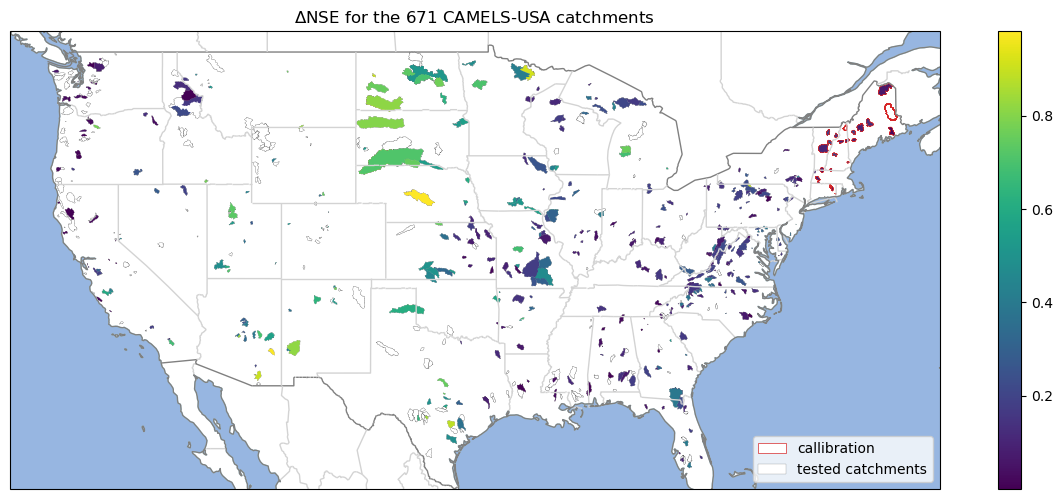

In [186]:
ax = plot_map(gdf_catchments_nse, "NSE_delta_best", save=True)

<GeoAxes: title={'center': '$\\Delta$log(NSE) for the 671 CAMELS-USA catchments'}>

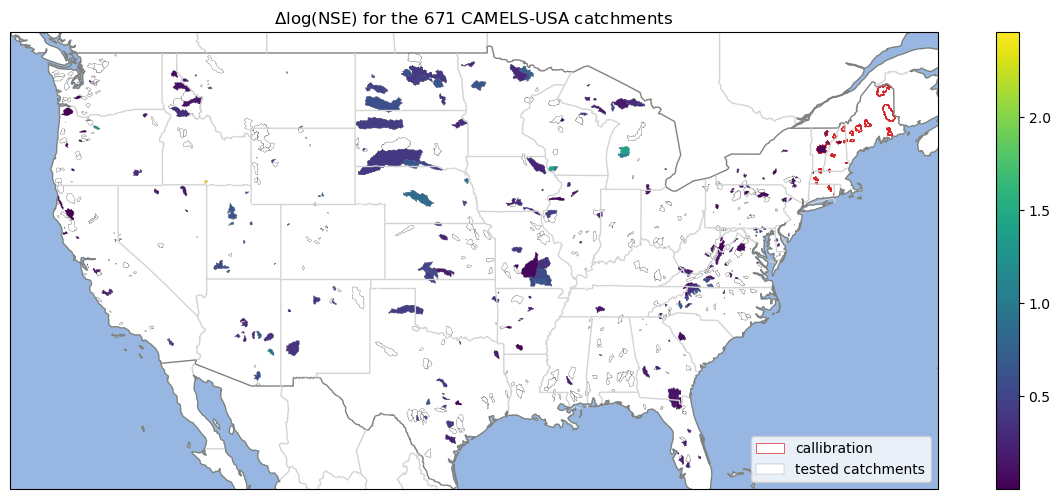

In [126]:
plot_map(gdf_catchments_nse, "log_NSE_delta_best")

<GeoAxes: title={'center': 'NSE_delta_mean for the 671 CAMELS-USA catchments'}>

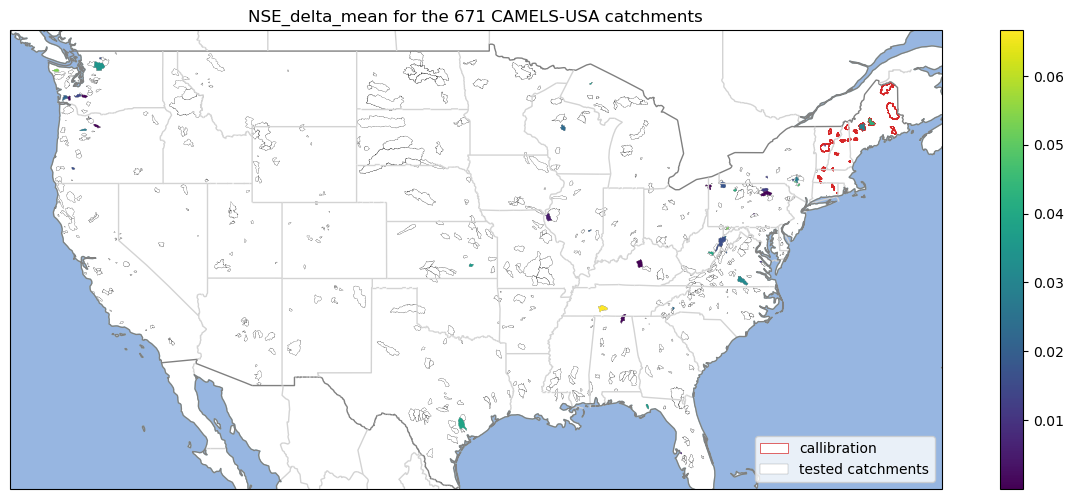

In [103]:
plot_map(gdf_catchments_nse, "NSE_delta_mean")

In [114]:
gdf_catchments_nse.columns

Index(['geometry', 'NSE_cal', 'log_NSE_cal', 'cal_Imax', 'cal_Ce', 'cal_Sumax',
       'cal_Beta', 'cal_Pmax', 'cal_Tlag', 'cal_Kf', 'cal_Ks', 'cal_FM',
       'cal_rmse', 'NSE_mean_DA', 'log_NSE_mean_DA', 'NSE_best_DA',
       'log_NSE_best_DA', 'NSE_delta_mean', 'NSE_delta_best',
       'log_NSE_delta_mean', 'log_NSE_delta_best'],
      dtype='object')

In [121]:
gdf_catchments_nse[['NSE_mean_DA', 'log_NSE_mean_DA', 'NSE_best_DA',
       'log_NSE_best_DA', 'NSE_delta_mean', 'NSE_delta_best',
       'log_NSE_delta_mean', 'log_NSE_delta_best']].sort_values('NSE_mean_DA',ascending=False).head(30)

NSE_mean_DA  log_NSE_mean_DA  NSE_best_DA  log_NSE_best_DA  \
HRU_id                                                                 
14301000     0.778720         0.903021     0.792900         0.929384   
11475560     0.724502         0.915487     0.732716         0.931833   
12013500     0.699968         0.811923     0.706465         0.862435   
14306500     0.686583         0.849892     0.692623         0.856313   
12117000     0.679692              NaN     0.723245         0.309720   
12025000     0.679519         0.834805     0.702380         0.883146   
11468500     0.678878         0.934673     0.706147         0.960784   
12414500     0.677517         0.404909     0.835403         0.773921   
11528700     0.676082         0.893932     0.729085         0.931294   
2350900      0.676073         0.541090     0.906106         0.883741   
4059500      0.663318         0.389071     0.983145         0.957421   
2371500      0.662908         0.681348     0.774805         0.804632   
14325000     0.661007         0.908995     0.678066         0.932375   
11476600     0.659546         0.928379     0.667221         0.937913   
2314500      0.657651         0.446708     0.942818         0.744599   
12035000     0.652627         0.141103     0.653238         0.148641   
14187000     0.652168         0.902292     0.672229         0.927564   
12043000     0.652149         0.738956     0.657026         0.775003   
1073000      0.650791         0.683696     0.896800         0.883470   
4057800      0.649979         0.058833     0.853414         0.773700   
1439500      0.649073         0.617488     0.909954         0.938648   
14222500     0.644519         0.597598     0.661828         0.664816   
14166500     0.637649         0.804968     0.668335         0.851486   
7346045      0.635060         0.439488     0.820105         0.671873   
4043050      0.634848         0.325944     0.713255         0.720768   
2372250      0.634453         0.588310     0.803209         0.782687   
1440000      0.630323         0.739647     0.807877         0.879639   
11482500     0.629129         0.933513     0.643867         0.950701   
4185000      0.627617         0.561075     0.837883         0.902577   
4045500      0.619717              NaN     0.969673         0.958813   

          NSE_delta_mean  NSE_delta_best  log_NSE_delta_mean  \
HRU_id                                                         
14301000             NaN             NaN                 NaN   
11475560             NaN             NaN                 NaN   
12013500        0.020596        0.027093                 NaN   
14306500             NaN             NaN                 NaN   
12117000             NaN        0.036005                 NaN   
12025000        0.014516        0.037376                 NaN   
11468500             NaN        0.009323                 NaN   
12414500             NaN        0.124590                 NaN   
11528700             NaN        0.000520                 NaN   
2350900              NaN        0.192265                 NaN   
4059500              NaN        0.229272                 NaN   
2371500              NaN        0.065490                 NaN   
14325000             NaN        0.016019                 NaN   
11476600             NaN             NaN                 NaN   
2314500              NaN        0.088850                 NaN   
12035000             NaN             NaN                 NaN   
14187000             NaN             NaN                 NaN   
12043000        0.053524        0.058401                 NaN   
1073000              NaN        0.220614                 NaN   
4057800              NaN        0.154169                 NaN   
1439500              NaN        0.216844                 NaN   
14222500             NaN             NaN                 NaN   
14166500             NaN             NaN                 NaN   
7346045              NaN        0.116966                 NaN   
4043050         0.035241        0.113647 

In [31]:
df_results_veg = df_res_all.copy()

In [32]:
df_char_vege.head(3)

frac_forest   lai_max  lai_diff   gvf_max  gvf_diff  \
HRU_id                                                         
1013500       0.9063  4.167304  3.340732  0.804567  0.371648   
1022500       0.9232  4.871392  3.746692  0.863936  0.337712   
1030500       0.8782  4.685200  3.665543  0.858502  0.351393   

         dom_land_cover_frac dom_land_cover  root_depth_50  root_depth_99  
HRU_id                                                                     
1013500             0.883452  Mixed Forests            NaN            NaN  
1022500             0.820493  Mixed Forests       0.237435       2.238444  
1030500             0.975258  Mixed Forests            NaN            NaN

In [33]:
for col in df_char_vege.columns:
    df_results_veg[col] = df_results_veg.apply(lambda x: df_char_vege.loc[int(x.name),col] 
                                                          if x.name in df_char_vege.index
                                                          else np.nan, 
                                                          axis=1)
# gdf_catchments_nse['NSE_mean_log'] = gdf_catchments_nse.apply(lambda x: df_res_all.loc[int(x.name),"NSE_mean_log"] 
#                                                               if x.name in df_res_all.index 
#                                                               else np.nan, 
#                                                               axis=1)

In [91]:
df_res_all.columns

Index(['NSE_cal', 'log_NSE_cal', 'cal_Imax', 'cal_Ce', 'cal_Sumax', 'cal_Beta',
       'cal_Pmax', 'cal_Tlag', 'cal_Kf', 'cal_Ks', 'cal_FM', 'cal_rmse',
       'NSE_mean_DA', 'log_NSE_mean_DA', 'NSE_best_DA', 'log_NSE_best_DA',
       'NSE_delta_mean', 'NSE_delta_best', 'log_NSE_delta_mean',
       'log_NSE_delta_best'],
      dtype='object')

In [90]:
df_char_vege.columns

Index(['frac_forest', 'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff',
       'dom_land_cover_frac', 'dom_land_cover', 'root_depth_50',
       'root_depth_99'],
      dtype='object')

In [82]:
lst_results_char = []
lst_df_char = [df_char_soil, df_char_hydro, df_char_geol, df_char_clim, df_char_vege]
lst_names = ['soil', 'hydro', 'geol', 'clim','vege']
dict_names_list = {}
for i, df_char in enumerate(lst_df_char):
    df_results_i = df_res_all.copy()
    for col in df_char.columns:
        df_results_i[col] = df_results_i.apply(lambda x: df_char.loc[int(x.name),col] 
                                                              if x.name in df_char.index
                                                              else np.nan, 
                                                              axis=1)
    lst_results_char.append(df_results_i)
    dict_names_list[lst_names[i]] = i
    

In [175]:
n_cols = 0
for i, df_char in enumerate(lst_df_char):
    n_cols += len(df_char.columns)
print(n_cols)

51


In [203]:
def plot_yvar(y_var, c_var, df, show_cal=False, save=False):
    n = 9
    fig, axs = plt.subplots(3,3,figsize=(10,8),sharey=True)
    axs = axs.flatten()

    df_plot = df[df[y_var] > 0]
    fig.suptitle(f'$\Delta$NSE vs parameters for {len(df_plot)} catchments\n Characteristic: {c_var}')
    hru_id_cal_in_results = list(set(df_plot.index).intersection(hru_id_cal))
    df_cal = df_plot.loc[hru_id_cal_in_results]
    
    for i, param in enumerate(param_names):
        ax = axs[i]
        df_plot.plot.scatter(f'cal_{param}',y_var,c=df_plot[c_var].values, ax=ax,    colormap='viridis_r',alpha=0.75)
        ax.set_xlabel("")
        ax.set_ylabel("$\Delta$NSE")
        ax.set_title(param)
        # ax.set_ylim(-0.05, 1.03)

        if show_cal:
            df_cal.plot.scatter(f'cal_{param}',y_var,edgecolor="C3",facecolor=None, ax=ax,alpha=0.75, zorder=10, label='Cal')
            if i == 1:
                ax.legend(fontsize="x-small")
            else:
                ax.get_legend().remove()
        
    fig.tight_layout()
    if save: 
        fig.savefig(figure_path / f'parameters_vs_{y_var}_{c_var}.png',bbox_inches='tight',dpi=150)

In [204]:
def plot_all(name_type, indicator, lst_results_char, dict_names_list, show_cal=False):
    df_results_char = lst_results_char[dict_names_list[name_type]]
    for var in df_results_char.columns[20:]:
        if type(df_results_char[var].iloc[0]) != str:
            plot_yvar(indicator ,var, df_results_char, show_cal=show_cal)

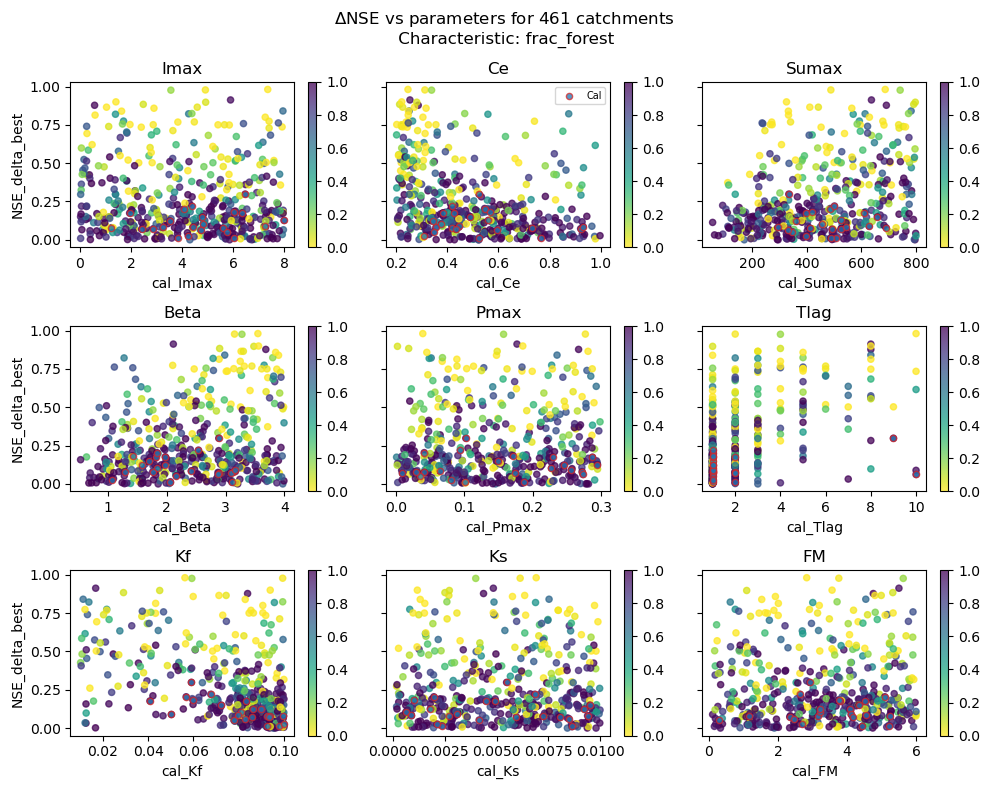

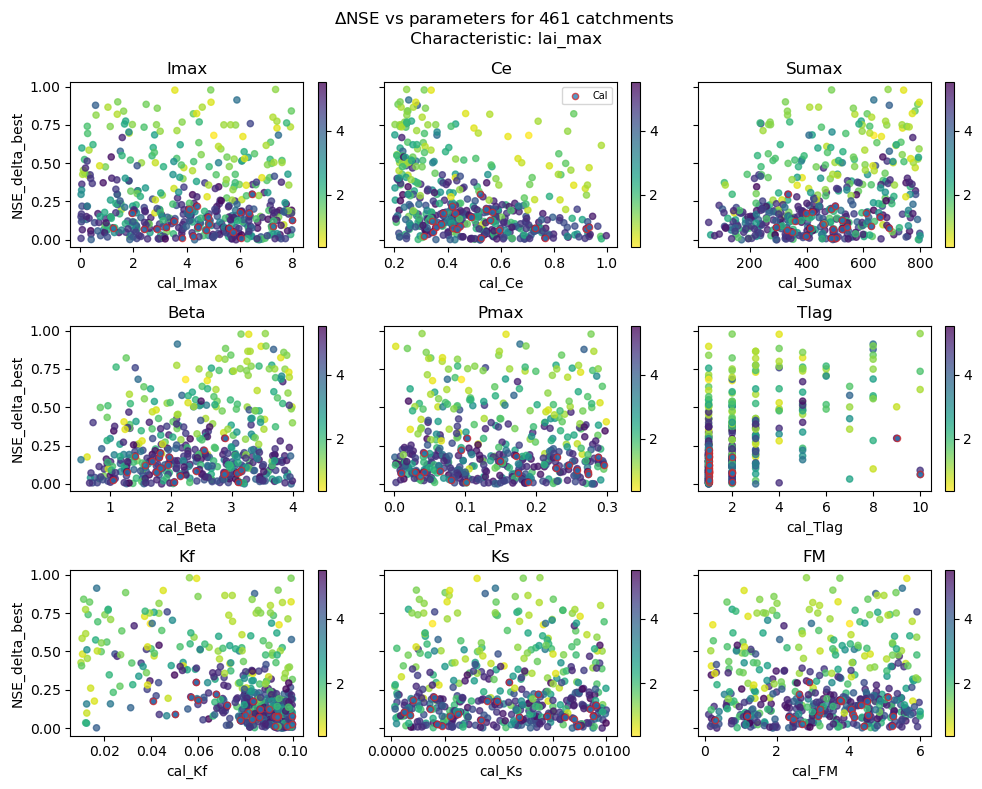

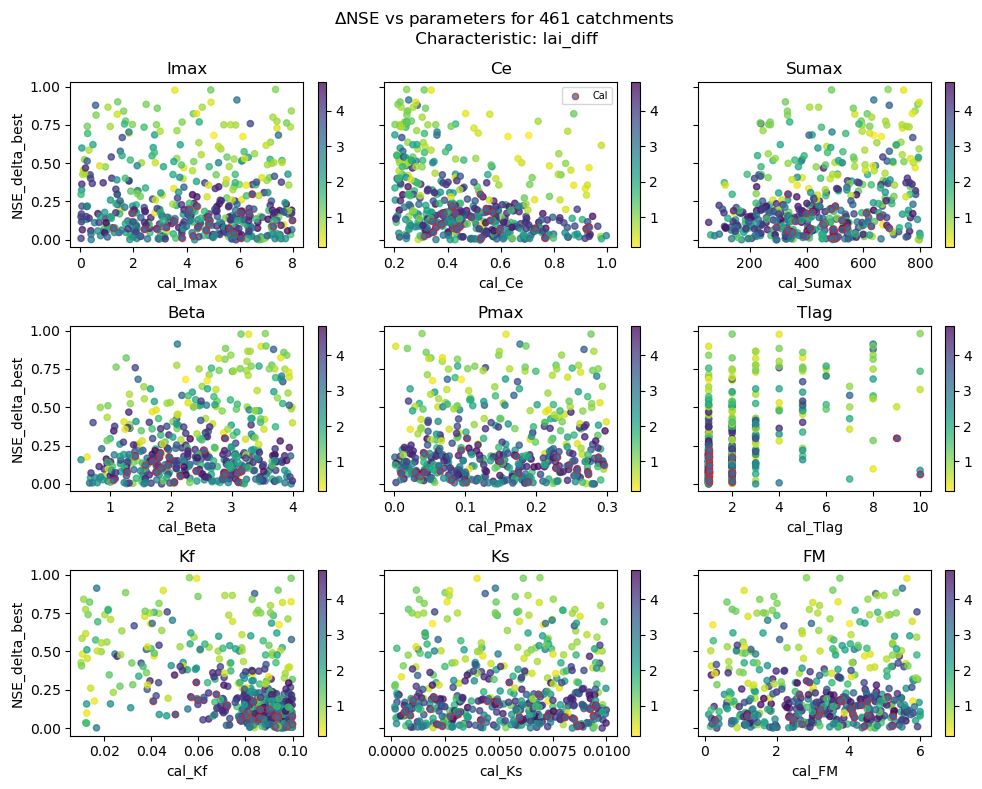

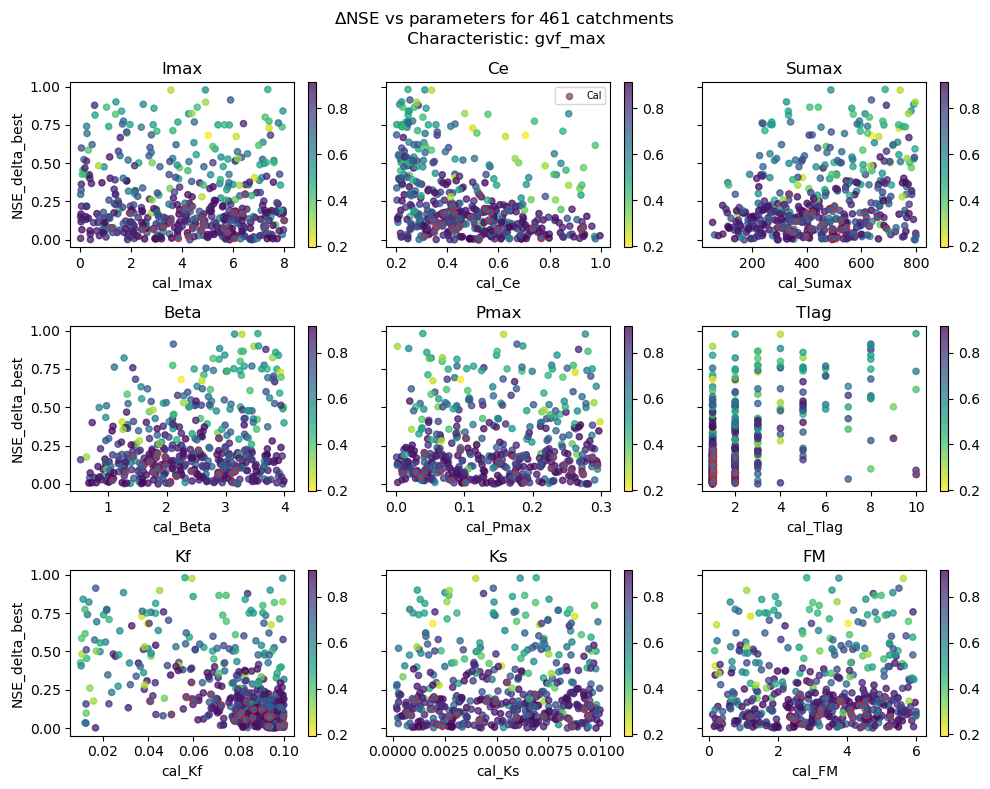

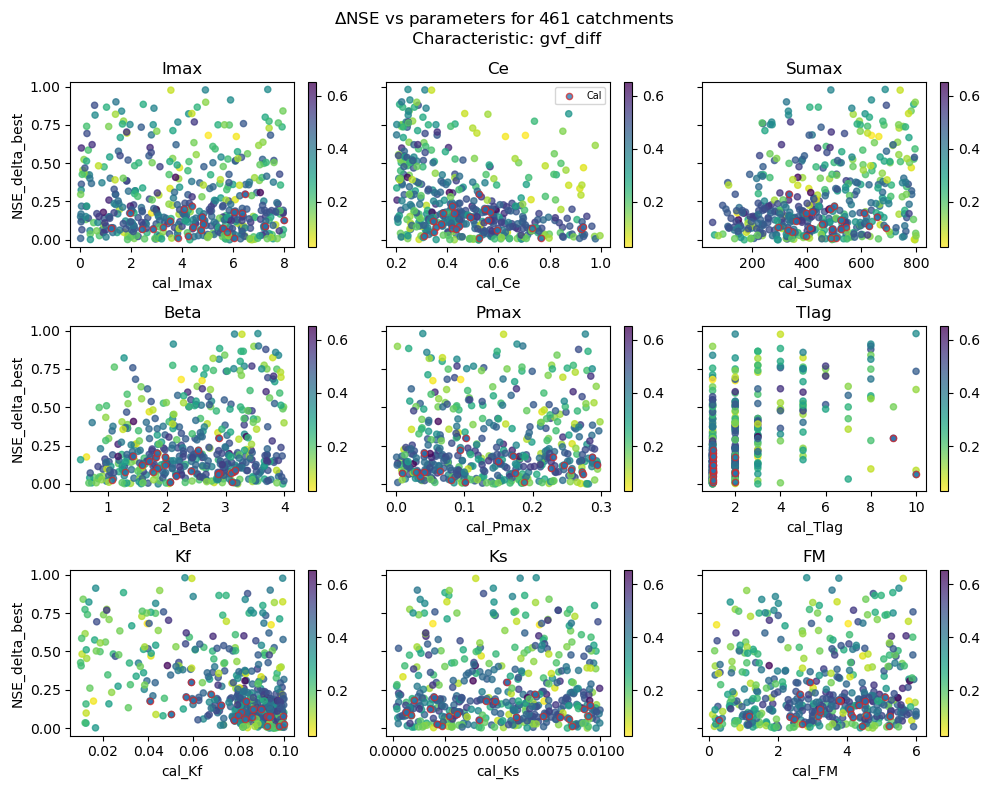

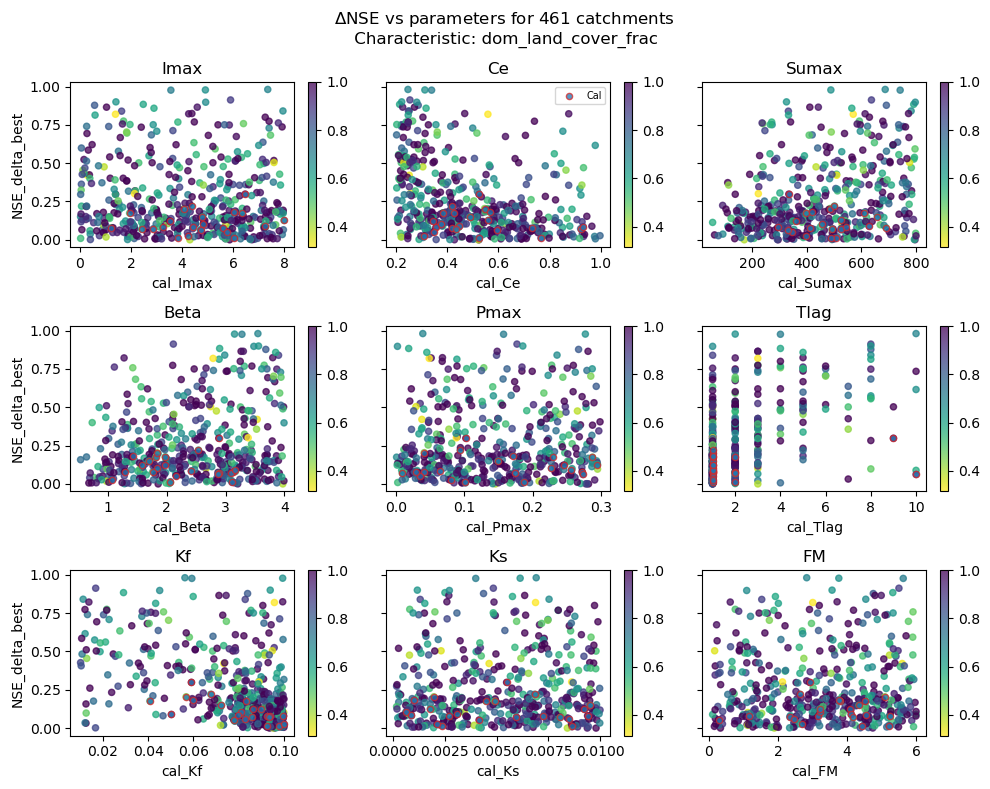

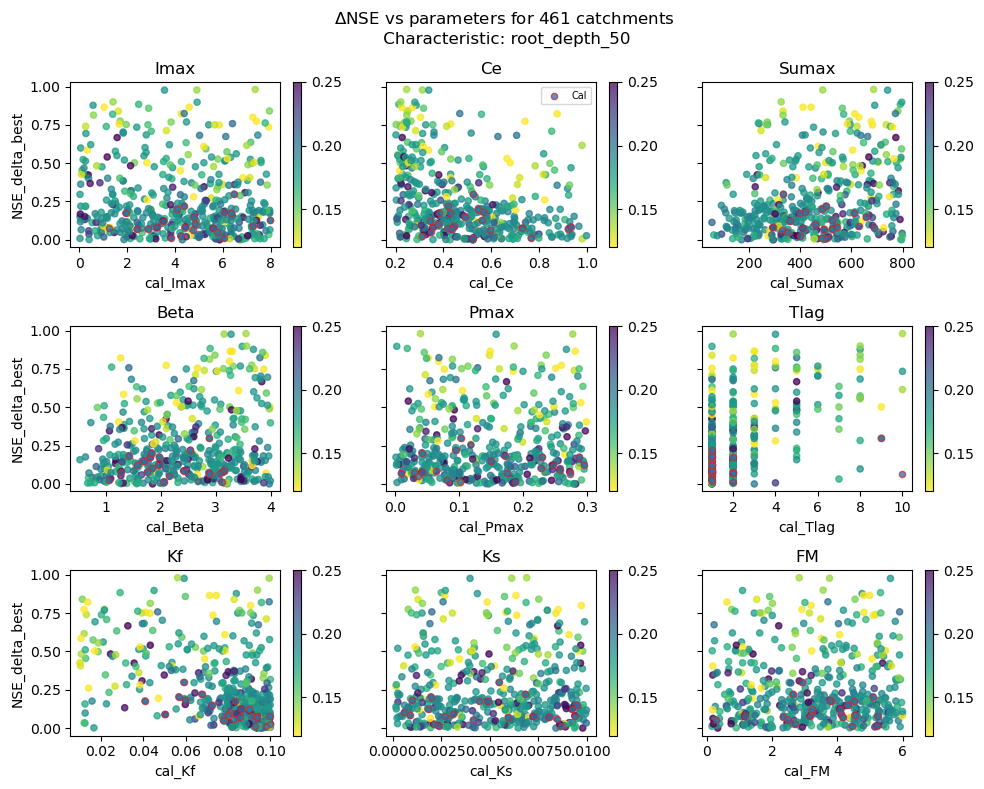

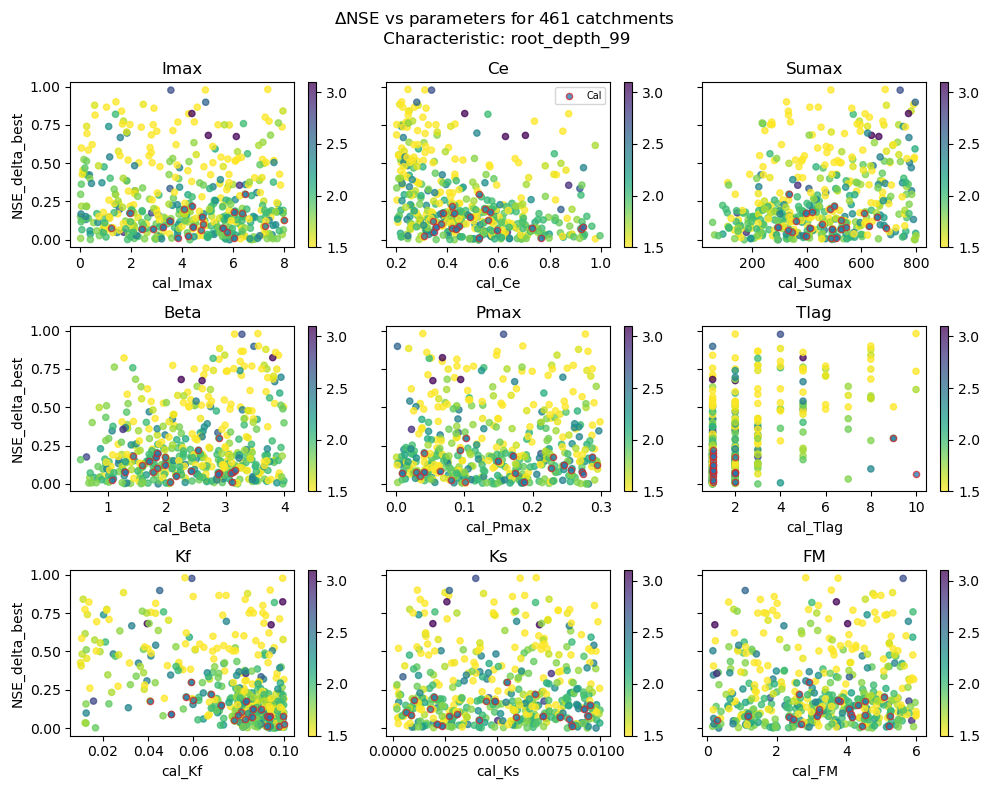

In [205]:
plot_all('vege', 'NSE_delta_best', lst_results_char, dict_names_list, show_cal=True)

In [ ]:
plot_yvar('NSE_delta_best', 'frac_forest', lst_results_char[dict_names_list['vege']], show_cal=True, save=False)

In [ ]:
plot_all('soil', 'NSE_delta_best', lst_results_char, dict_names_list)

In [ ]:
plot_all('vege', 'NSE_delta_best', lst_results_char, dict_names_list)

In [ ]:
plot_all('clim', 'NSE_delta_best', lst_results_char, dict_names_list, True)

In [ ]:
plot_all('clim', 'NSE_delta_best', lst_results_char, dict_names_list, True)

In [ ]:
plot_all('geol', 'NSE_delta_best', lst_results_char, dict_names_list)

In [ ]:
plot_all('vege', 'NSE_delta_mean', lst_results_char, dict_names_list)